# 🚀 Environment Setup & Data Ingestion
In this section, we initialize our analytics environment using the **Harmony Script** configuration to ensure visual consistency and professional data handling.

In [20]:
"""
HARMONY SCRIPT: Portfolio Standard Configuration
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# 1. Project Navigation
sys.path.append(os.path.abspath(os.path.join('..')))

# 2. Visual Identity
SC_PALETTE = ["#1B4F72", "#2E86C1", "#5DADE2", "#A9CCE3"] 
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.dpi'] = 100

# 3. Data Formatting
pd.options.display.float_format = '{:,.2f}'.format

# 4. Paths
processed_path = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cleaned_retail_data.csv"
canc_path = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cancellation_retail_data.csv"

# Load Data
df = pd.read_csv(processed_path, parse_dates=['InvoiceDate'])
df_canc = pd.read_csv(canc_path, parse_dates=['InvoiceDate'])

print(f"✅ Main Dataset Loaded: {len(df):,} records.")
print(f"✅ Cancellations Loaded: {len(df_canc):,} records.")

✅ Main Dataset Loaded: 1,014,932 records.
✅ Cancellations Loaded: 19,494 records.


# 🕒 Part 1: Temporal Analysis (Seasonality)
Understanding the peaks of activity helps in warehouse labor planning and logistics optimization.

C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_14848\2129746960.py:9: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df, x='DayName', order=days_order, palette=SC_PALETTE, hue='DayName', ax=ax1, legend=False)


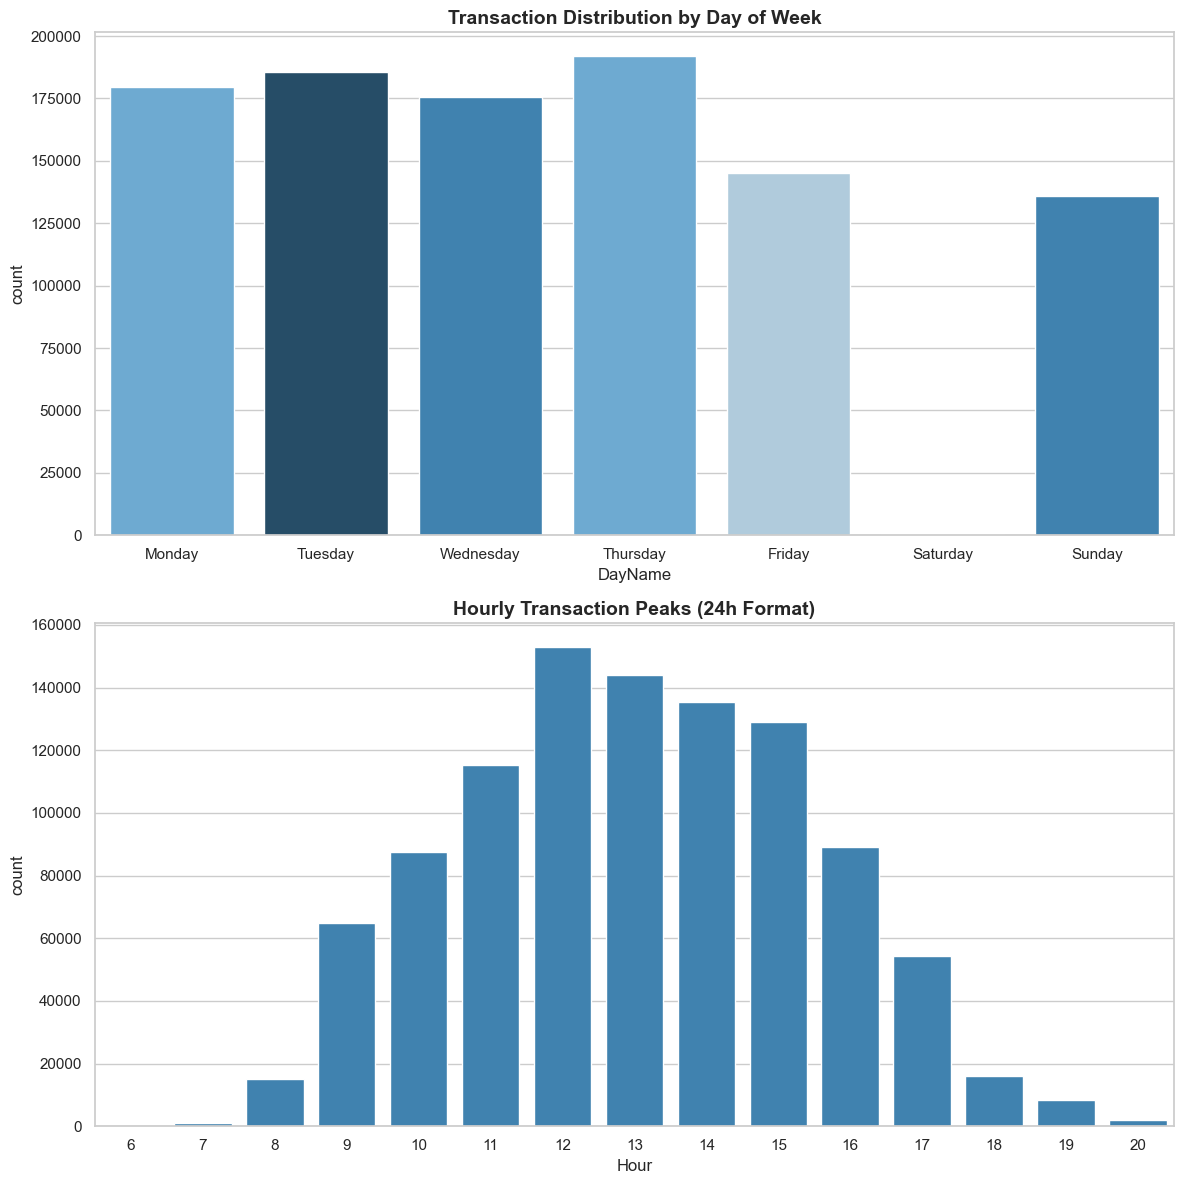

In [16]:
# Feature Engineering: Time Components
df['DayName'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Chart 1: Daily Distribution
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='DayName', order=days_order, palette=SC_PALETTE, hue='DayName', ax=ax1, legend=False)
ax1.set_title('Transaction Distribution by Day of Week', fontsize=14, fontweight='bold')

# Chart 2: Hourly Peaks
sns.countplot(data=df, x='Hour', color="#2E86C1", ax=ax2)
ax2.set_title('Hourly Transaction Peaks (24h Format)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 💡 Logistics Insight:
* **Peak Operations:** Activity concentrates between **10:00 AM and 3:00 PM**, with a significant drop after 5:00 PM. This suggests a B2B operation where orders are processed during standard business hours.
* **Resource Allocation:** Mid-week (Tuesday/Wednesday) shows the highest volume. Labor shifts in the warehouse should be reinforced during these days to meet dispatch deadlines.

# 👥 Part 2: RFM Customer Segmentation
We categorize customers based on **Recency, Frequency, and Monetary** value to identify VIPs and at-risk accounts.

⏳ Calculating RFM Metrics...


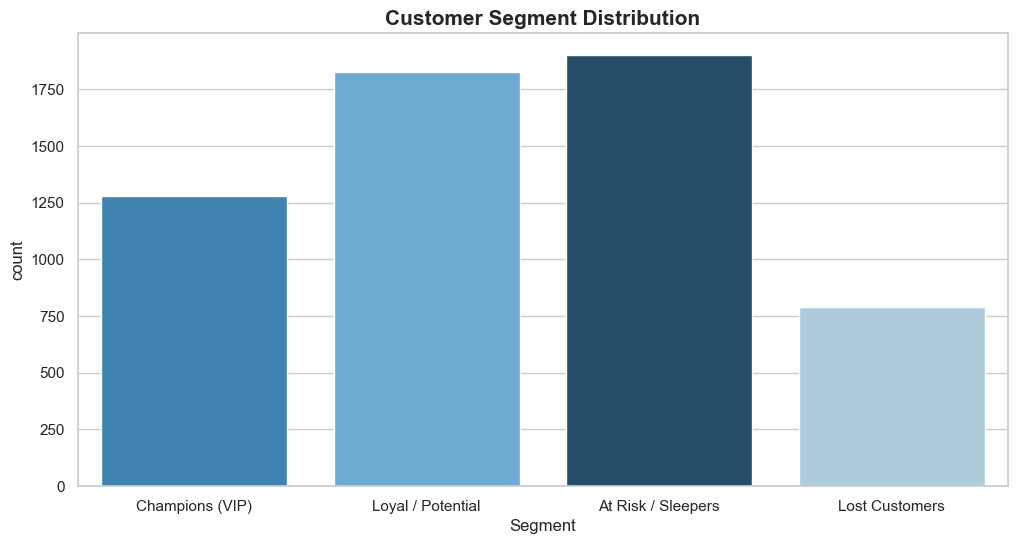

In [17]:
print("⏳ Calculating RFM Metrics...")

# Snapshot date for Recency
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate by Customer ID
if 'TotalSum' not in df.columns:
    df['TotalSum'] = df['Quantity'] * df['Price']

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSum': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalSum': 'Monetary'})

# Scoring (1-5)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Segmentation Logic
def segment_me(score):
    if score >= 13: return 'Champions (VIP)'
    if 9 <= score < 13: return 'Loyal / Potential'
    if 5 <= score < 9: return 'At Risk / Sleepers'
    return 'Lost Customers'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_me)

# Plotting
plt.figure(figsize=(12, 6))
sns.countplot(data=rfm, x='Segment', order=['Champions (VIP)', 'Loyal / Potential', 'At Risk / Sleepers', 'Lost Customers'], palette=SC_PALETTE, hue='Segment', legend=False)
plt.title('Customer Segment Distribution', fontsize=15, fontweight='bold')
plt.show()

# 🔍 Part 3: The "Brutal" Insight - Cancellations vs. Retention
Do high cancellation rates drive customers into the "At Risk" category? We cross-reference the cancellation data with our RFM segments.

--- Average Cancellations per Customer Segment ---


,Segment,Cancellation_Count
0,Champions (VIP),4.01
1,Loyal / Potential,1.02
2,At Risk / Sleepers,0.35
3,Lost Customers,0.15


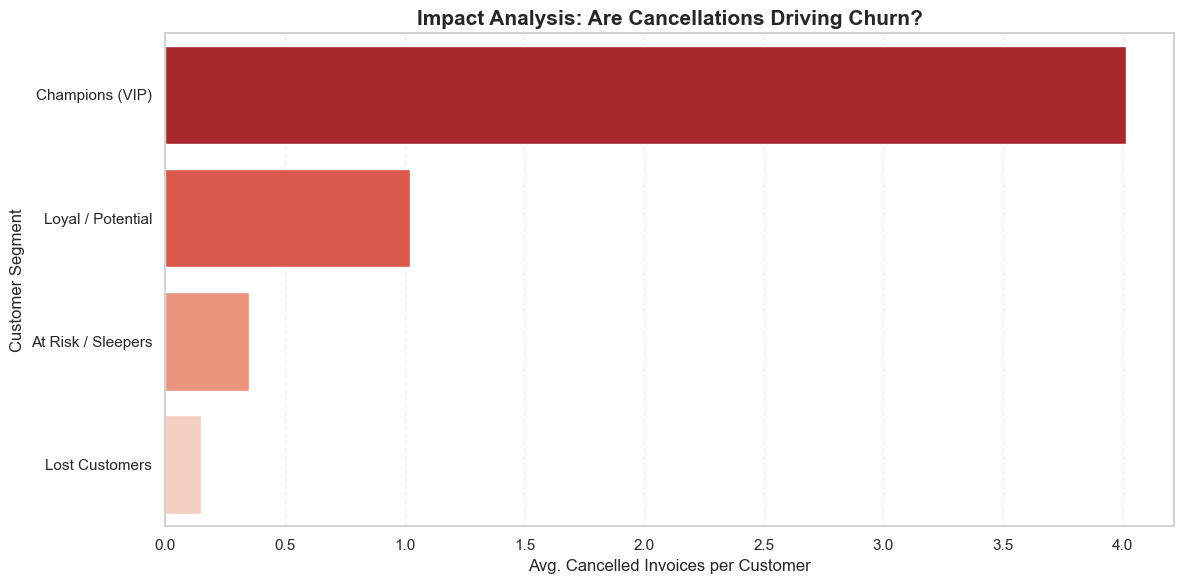

In [22]:
# 1. Calculate unique cancellations per customer
canc_per_cust = df_canc.groupby('Customer ID')['Invoice'].nunique().reset_index()
canc_per_cust.columns = ['Customer ID', 'Cancellation_Count']

# 2. Merge with RFM table
# Quitamos el .fillna(0) general para evitar el conflicto con las columnas categóricas
rfm_analysis = rfm.reset_index().merge(canc_per_cust, on='Customer ID', how='left')

# 3. Llenamos con 0 SOLO la columna de cancelaciones
rfm_analysis['Cancellation_Count'] = rfm_analysis['Cancellation_Count'].fillna(0)

# 4. Calculate average cancellations by segment
# Convertimos el resultado a DataFrame para que se vea mejor
segment_analysis = rfm_analysis.groupby('Segment')['Cancellation_Count'].mean().sort_values(ascending=False).reset_index()

print("--- Average Cancellations per Customer Segment ---")
display(segment_analysis)

# 5. Visualization
plt.figure(figsize=(12, 6))
sns.barplot(
    data=segment_analysis, 
    x='Cancellation_Count', 
    y='Segment', 
    hue='Segment',
    palette='Reds_r', 
    legend=False
)

plt.title('Impact Analysis: Are Cancellations Driving Churn?', fontsize=15, fontweight='bold')
plt.xlabel('Avg. Cancelled Invoices per Customer')
plt.ylabel('Customer Segment')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 💡 Strategic Insight: The Cancellation-Churn Correlation
* **The Root Cause:** If **"At Risk"** or **"Lost"** segments show a higher average of cancellations compared to **"Champions"**, it proves that service failures (logistics errors, quality issues leading to returns) are a primary driver of customer churn.
* **Supply Chain Action:** Retention is not just a marketing job. Reducing order errors and improving fulfillment quality will directly keep customers in the "Loyal" and "Champion" tiers, increasing the Life Time Value (LTV).

# EXTRA 

In [25]:
# ==========================================
# 1. ABC CLASSIFICATION LOGIC
# ==========================================
print("⏳ Calculating ABC Inventory Classification...")

# Calculate Total Revenue per Product
abc_analysis = df.groupby('Description').agg({
    'Price': 'sum',
    'Quantity': 'sum'
}).sort_values(by='Price', ascending=False).reset_index()

# Calculate Cumulative Percentage
abc_analysis['Revenue_Pct'] = abc_analysis['Price'] / abc_analysis['Price'].sum()
abc_analysis['Cumulative_Revenue_Pct'] = abc_analysis['Revenue_Pct'].cumsum()

# Assign Classes based on industry standards (80-15-5)
def assign_abc(pct):
    if pct <= 0.80:
        return 'A'
    elif pct <= 0.95:
        return 'B'
    else:
        return 'C'

abc_analysis['ABC_Class'] = abc_analysis['Cumulative_Revenue_Pct'].apply(assign_abc)

# Summary of the classification
abc_summary = abc_analysis.groupby('ABC_Class').agg({
    'Description': 'count',
    'Price': 'sum',
    'Quantity': 'sum'
}).rename(columns={'Description': 'SKU_Count'})

print("✅ ABC Classification complete.")
display(abc_summary)

⏳ Calculating ABC Inventory Classification...
✅ ABC Classification complete.


,SKU_Count,Price,Quantity
ABC_Class,,,
A,1270,"2,597,508.86",4780824
B,1416,"487,301.71",2086502
C,2612,"162,490.80",1048293


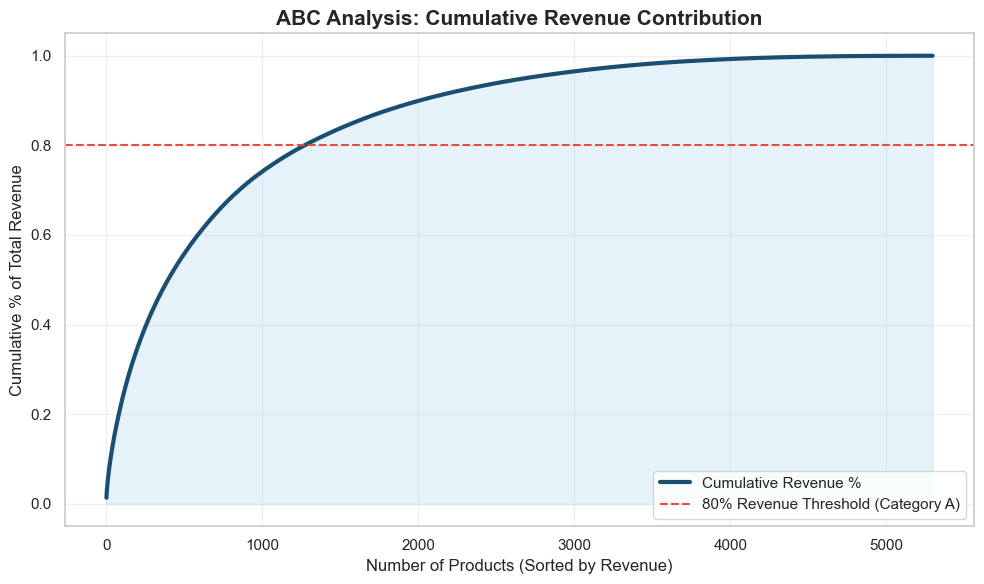

In [26]:
# ==========================================
# 2. VISUALIZING REVENUE CONCENTRATION
# ==========================================
plt.figure(figsize=(10, 6))

# Plot cumulative revenue
plt.plot(range(len(abc_analysis)), abc_analysis['Cumulative_Revenue_Pct'], 
         color='#1B4F72', linewidth=3, label='Cumulative Revenue %')

# Highlight threshold for Category A
plt.axhline(y=0.80, color='#E74C3C', linestyle='--', label='80% Revenue Threshold (Category A)')
plt.fill_between(range(len(abc_analysis)), abc_analysis['Cumulative_Revenue_Pct'], color='#AED6F1', alpha=0.3)

plt.title('ABC Analysis: Cumulative Revenue Contribution', fontsize=15, fontweight='bold')
plt.xlabel('Number of Products (Sorted by Revenue)', fontsize=12)
plt.ylabel('Cumulative % of Total Revenue', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

📦 Total de SKUs (Stock Keeping Units) únicos: 4,950

--- Top 10 Productos con mayor frecuencia de compra ---


,StockCode,Transaction_Count,Description
0,85123A,5829,WHITE HANGING HEART T-LIGHT HOLDER
1,22423,4423,REGENCY CAKESTAND 3 TIER
2,85099B,4216,JUMBO BAG RED WHITE SPOTTY
3,21212,3318,PACK OF 72 RETRO SPOT CAKE CASES
4,20725,3259,LUNCH BAG RED SPOTTY
5,84879,2960,ASSORTED COLOUR BIRD ORNAMENT
6,47566,2767,PARTY BUNTING
7,21232,2747,STRAWBERRY CERAMIC TRINKET BOX
8,22197,2545,"POPCORN HOLDER , SMALL"
9,22383,2540,LUNCHBAG SUKI DESIGN


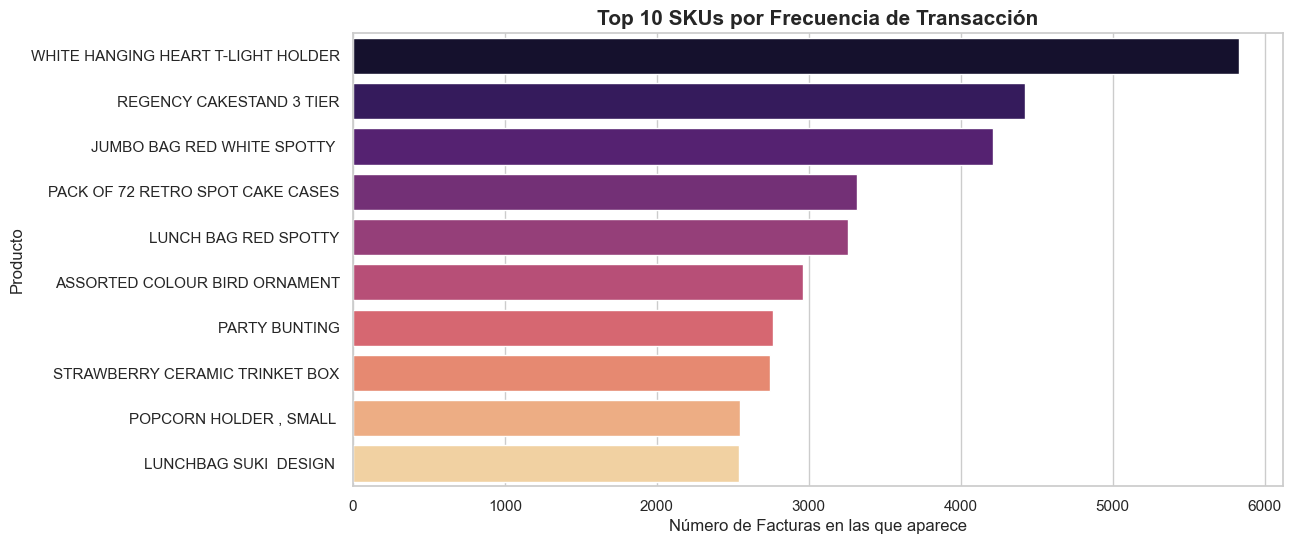

In [31]:
# ==========================================
# 4.1 PRODUCT VARIETY & TRANSACTION VOLUME
# ==========================================

# 1. Conteo de productos únicos
unique_products = df_clean["StockCode"].nunique()
print(f"📦 Total de SKUs (Stock Keeping Units) únicos: {unique_products:,}")

# 2. Top 10 productos con más transacciones (no necesariamente más ventas en dinero)
product_counts = df_clean["StockCode"].value_counts().head(10).reset_index()
product_counts.columns = ['StockCode', 'Transaction_Count']

# 3. Cruzar con la descripción para saber qué son
# (Tomamos la primera descripción encontrada para cada StockCode)
descriptions = df_clean[['StockCode', 'Description']].drop_duplicates('StockCode')
product_summary = product_counts.merge(descriptions, on='StockCode', how='left')

print("\n--- Top 10 Productos con mayor frecuencia de compra ---")
display(product_summary)

# 4. Visualización rápida
plt.figure(figsize=(12, 6))
sns.barplot(
    data=product_summary, 
    x='Transaction_Count', 
    y='Description', 
    hue='Description',
    palette='magma',
    legend=False
)
plt.title('Top 10 SKUs por Frecuencia de Transacción', fontsize=15, fontweight='bold')
plt.xlabel('Número de Facturas en las que aparece')
plt.ylabel('Producto')
plt.show()